# Predictive Model for Mailout Campaign
    (1 GridSearchCV for hyper-parameter tunning
    (2 Model Evaluation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [3]:
from src.model_pipeline import (
    clean_data,
    build_model,
    save_model_result,
    model_evaluation,
)

## Data Preprocessing

In [4]:
#gather train dataset to train model
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# use method in data_wranggling part to clean data
mailout_train_clean = clean_data(mailout_train)

Dataset has 0 missing value.


In [6]:
X = mailout_train_clean[[col for col in mailout_train_clean.columns if col not in ['LNR', 'RESPONSE' ]]]
y = mailout_train_clean['RESPONSE']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Handle imbalanced dataset

In [8]:
y_train.mean() # highly imbalanced

0.012263757643135075

In [9]:
# Use SMOTE to increase positive sample
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

## GridSearchCV for Hyper-parameter tunning
    - the pipeline will apply StandardScaler(), PCA(n_components=100) and XGBClassifier()
    - tunning paramter to reduce overfitting: gamma, max_depth, min_child_weight, subsample,colsample

In [12]:
xgb_model = build_model('XGBoost')
xgb_model.fit(X_train_sm, y_train_sm)
xgb_cv_result = save_model_result(xgb_model)

In [32]:
rf_model = build_model('Random Forecast')
rf_model.fit(X_train_sm, y_train_sm)
rf_cv_result = save_model_result(rf_model)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.6min finished


In [33]:
logit_model = build_model('Logistic')
logit_model.fit(X_train_sm, y_train_sm)
logit_cv_result = save_model_result(logit_model)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.8s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.7s finished


## Model Evaluation
    - tn, fp, fn, tp
    - auc score

In-Sample Test
precision: 0.21616161616161617, 
recall: 0.9093484419263456, 
accuracy: 0.9584491384102279, 
auc: <function auc at 0x7fcf10662320>


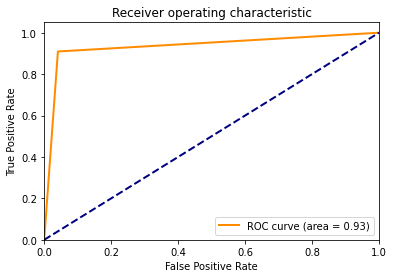

Off-Sample Test
precision: 0.01775147928994083, 
recall: 0.0670391061452514, 
accuracy: 0.941388066017774, 
auc: <function auc at 0x7fcf10662320>



In [34]:
model_evaluation(X_train, X_test, y_train, y_test, xgb_model)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


In-Sample Test
precision: nan, 
recall: 0.0, 
accuracy: 0.987736242356865, 
auc: <function auc at 0x7fcf10662320>


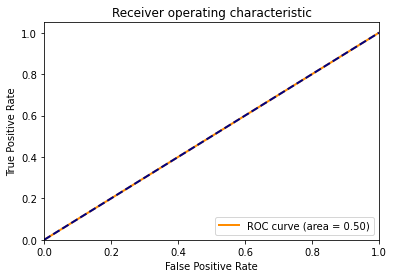

Off-Sample Test
precision: nan, 
recall: 0.0, 
accuracy: 0.9873748060375229, 
auc: <function auc at 0x7fcf10662320>



In [35]:
model_evaluation(X_train, X_test, y_train, y_test, rf_model)

In-Sample Test
precision: 0.020257438278117747, 
recall: 0.2719546742209632, 
accuracy: 0.8297665369649806, 
auc: <function auc at 0x7fcf10662320>


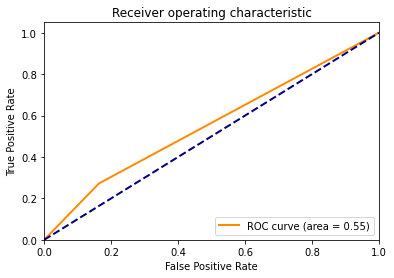

Off-Sample Test
precision: 0.019162210338680926, 
recall: 0.24022346368715083, 
accuracy: 0.8351671603893356, 
auc: <function auc at 0x7fcf10662320>



In [36]:
model_evaluation(X_train, X_test, y_train, y_test, logit_model)

**High in sample test score but low out-of-sample score shows overfitting  still significant in the model.**

### Feature importance

In [37]:
feature_importance = pd.DataFrame({
    'pca': range(100),
    'Feature importance': xgb_model.best_estimator_._final_estimator.feature_importances_
})
feature_importance.sort_values(by='Feature importance', ascending=False).head(10)

,pca,Feature importance
29,29,0.048964
27,27,0.038226
37,37,0.023328
68,68,0.022182
92,92,0.021343
72,72,0.019400
3,3,0.019277
96,96,0.019072
57,57,0.017591
95,95,0.017254


## Implement Model

In [42]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test_clean = clean_data(mailout_test)
X_test = mailout_test_clean[[col for col in mailout_test_clean.columns if col not in ['LNR']]]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dataset has 0 missing value.


In [44]:
y_pred = xgb_model.predict(X_test)

In [49]:
## prepare file for Kaggle submission
pd.DataFrame({
    'LNR': mailout_test.LNR,
    'RESPONSE': y_pred
}).to_csv('Arvato_Capstone_Kaggle_Submission.csv', index=False)